In [8]:
from pathlib import Path

import numpy as np
from tqdm import tqdm

import idmlaser.kmcurve as kmcurve
import idmlaser.pyramid as pyramid
from idmlaser.models.numpynumba import STATE_ACTIVE
from idmlaser.models.numpynumba import NumbaSpatialSEIR
from idmlaser.numpynumba import DemographicsByYear
from idmlaser.utils import PriorityQueueNB
from idmlaser.utils import PropertySet

SCRIPT_PATH = Path.cwd().absolute()

meta_params = PropertySet(
    {
        "ticks": 365,
        "nodes": 1,
        "seed": 20240702,
        "output": Path.cwd() / "outputs",
    }
)

model_params = PropertySet(
    {
        "exp_mean": np.float32(7.0),
        "exp_std": np.float32(1.0),
        "inf_mean": np.float32(7.0),
        "inf_std": np.float32(1.0),
        "r_naught": np.float32(14.0),
        "seasonality_factor": np.float32(0.125),
        "seasonality_offset": np.float32(182),
    }
)

params = PropertySet(meta_params, model_params)

model = NumbaSpatialSEIR(params)

# Ignore optional parameters, cbr, mortality, and immigration
demographics = DemographicsByYear(nyears=1, nnodes=1)
CAPACITY = 1_000_000
demographics.initialize(initial_population=CAPACITY)

max_capacity = CAPACITY
INFECTIONS = 10
initial = np.zeros((1, 4), dtype=np.uint32)
initial[0, :] = [CAPACITY - INFECTIONS, 0, INFECTIONS, 0]  # S, E, I, R
network = np.zeros((1, 1), dtype=np.float32)  # 1x1 network
model.initialize(max_capacity, demographics, initial, network)


Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 20240412, 'ticks': 365, 'nodes': 1, 'seed': 20240702, 'output': PosixPath('/Users/christopherlorton/projects/laser/tests/outputs'), 'seasonality_factor': 0.125, 'seasonality_offset': 182.0, 'beta': 2.0}
Initializing model with 1 nodes: (initial population: 1,000,000 maximum capacity: 1,000,000)


In [9]:
def init_dobs_dods(filename, dobs, dods, seed=20240703):
    popdata = pyramid.load_pyramid_csv(filename)
    prng = np.random.default_rng(seed)
    agedist = pyramid.AliasedDistribution(popdata[:, 4], prng=prng)  # ignore sex for now
    indices = agedist.sample(dobs.shape[0])
    minage = popdata[:, 0] * 365  # closed interval (include this value)
    limage = (popdata[:, 1] + 1) * 365  # open interval (do not include this value)
    print("Converting age-bin indices to dates of birth...")
    for i in tqdm(range(len(popdata))):
        mask = indices == i
        dobs[mask] = prng.integers(low=minage[i], high=limage[i], size=mask.sum())
    print("Converting dates of birth to dates of death...")
    for i in tqdm(range(len(dobs))):
        dods[i] = kmcurve.predicted_day_of_death(dobs[i])
    dods -= dobs.astype(dods.dtype)  # renormalize to be relative to _now_ (t=0)
    dobs = -dobs  # all _living_ agents have dates of birth before now (t=0)

    return


model.population.add_property("dod", dtype=np.int32)
init_dobs_dods(
    SCRIPT_PATH / "USA-pyramid-2023.csv", model.population.dob, model.population.dod, seed=params.seed
)  # 2023 is the most recent year of data

print(f"Pushing {model.population.dod.shape[0]} agents onto the priority queue...")
pq = PriorityQueueNB(model.population.dod.shape[0], model.population.dod)
for i in tqdm(range(model.population.dod.shape[0])):
    pq.push(i)

# temp
# print(f"Popping {model.population.dod.shape[0]} agents off the priority queue...")
# for _ in tqdm(range(model.population.dod.shape[0])):
#     pq.pop()

model.queues = [pq]



Reading data from '/Users/christopherlorton/projects/laser/tests/USA-pyramid-2023.csv' ...
Converting age-bin indices to dates of birth...


100%|██████████| 21/21 [00:00<00:00, 588.99it/s]


Converting dates of birth to dates of death...


100%|██████████| 1000000/1000000 [00:06<00:00, 161655.95it/s]


Pushing 1000000 agents onto the priority queue...


100%|██████████| 1000000/1000000 [00:01<00:00, 951873.29it/s]


In [10]:
# HACK, HACK, HACK

def non_disease_deaths(model, tick) -> None:
    states = model.population.states
    pq = model.queues[0]  # only one node, right now
    while (pq.size > 0) and (pq.peekv() == tick):
        i = pq.popi()
        states[i] = 0  # dead
    return


model._phases.insert(0, non_disease_deaths)

# KCAH, KCAH, KCAH


In [11]:
model.run(params.ticks)

# model.report : ticks x channels x nodes
print(model.report.shape)
print(model.report[30:50, :, 0])



100%|██████████| 365/365 [00:01<00:00, 340.72it/s]

elapsed time: 0:00:01.072912
(366, 5, 1)
[[892203  88788  13811   2303   2895]
 [860906 115044  18009   3081   2960]
 [821309 147823  23712   4120   3036]
 [771453 188552  31354   5549   3092]
 [709866 238403  41178   7385   3168]
 [635440 297538  54025   9761   3236]
 [549207 364258  70372  12870   3293]
 [451987 436138  91753  16779   3343]
 [349029 507020 118436  22130   3385]
 [246655 568564 152157  29186   3438]
 [155163 609350 193496  38512   3479]
 [ 82570 620134 243256  50530   3510]
 [ 34673 594121 301566  66108   3532]
 [ 10265 533249 366508  86441   3537]
 [  1653 447128 435291 112354   3574]
 [    60 349161 502042 145171   3566]
 [     0 252052 557799 186583   3566]
 [     0 164912 593673 237855   3560]
 [     0  95235 600757 300445   3563]
 [     0  46717 575902 373826   3555]]


In [12]:
metrics = np.array(model.metrics)
for c in range(metrics.shape[1]):
    if c == 0:
        continue
    print(f"{model._phases[c-1].__name__:20}: {metrics[:,c].sum():11,} μs")
print("====================================")
print(f"total               : {metrics[:, 1:].sum():,} μs")


non_disease_deaths  :      71,745 μs
vital_dynamics      :       9,021 μs
infection_update    :      74,423 μs
incubation_update   :      82,077 μs
transmission_update :     503,753 μs
report_update       :     321,533 μs
total               : 1,062,552 μs


In [13]:
print("Goodbye [cruel], world!")


Goodbye [cruel], world!


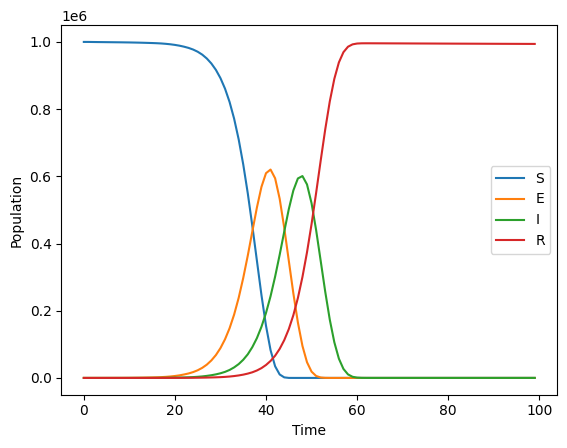

In [14]:
import matplotlib.pyplot as plt

# Extract the "S", "E", "I", and "R" channels from model.report
s_channel = model.report[0:100, 0, 0]
e_channel = model.report[0:100, 1, 0]
i_channel = model.report[0:100, 2, 0]
r_channel = model.report[0:100, 3, 0]

# Plot the channels
plt.plot(s_channel, label="S")
plt.plot(e_channel, label="E")
plt.plot(i_channel, label="I")
plt.plot(r_channel, label="R")

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()

# Show the plot
plt.show()